In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
# import theano as th
# import theano.tensor as T
# import tensorflow as tf
# import tensorflow.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from keras.models import Model
from IPython import display

from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# X_train = X_train.reshape(X_train.shape[0],img_rows, img_cols,1)
# X_test = X_test.reshape(X_test.shape[0],img_rows, img_cols,1)

X_train = X_train.reshape(X_train.shape[0],1,img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0],1,img_rows, img_cols,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [3]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [4]:
shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
nch = 200

# Build Generative model ...
nch = 200 # 这个值可以自己设定
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(100, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(50, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H) # (1,28,28)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=shp) # 输入尺寸和训练数据一致
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False) # 先冻结判定器，只训练生成器
# Build stacked GAN model
gan_input = Input(shape=[100])  # 随机数组成的矩阵
H = generator(gan_input)  # 生成器模型
gan_V = discriminator(H)  # 判定器模型
GAN = Model(gan_input, gan_V)  # 完整的一个模型
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


(1, 28, 28)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(39200, kernel_initializer="glorot_normal")`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (3, 3), padding="same", kernel_initializer="glorot_uniform")`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (3, 3), padding="same", kernel_initializer="glorot_uniform")`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 28, 28)       180100    
__________

D:\anaconda\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", strides=(2, 2), padding="same")`
D:\anaconda\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), activation="relu", strides=(2, 2), padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 14, 14)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 14, 14)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 7, 7)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 7, 7)         0         
__________

In [27]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [28]:
# 画出生成器得出的图片
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


D:\anaconda\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [7]:
ntrain = 10000
# random.sample(sequence,k)  从指定序列中随机获取k个元素作为一个片段返回，sample函数不会修改原有序列
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)  # X_train shape: (60000, 1, 28, 28) 
XT = X_train[trainidx,:,:,:]  # 从xtrain中选取10000条数据 （10000,1,28,28） 真实照片

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])  # 输出（10000,100）的矩阵，元素的值在（0，1）之间，随机噪声
generated_images = generator.predict(noise_gen)  # 生成器生成的假图片
X = np.concatenate((XT, generated_images))  # 将真、假图片进行混合

n = XT.shape[0] 
y = np.zeros([2*n,2])  # 这里用2*n是因为真假数据混合了，而且他们数量相等
y[:n,1] = 1  # 从0到n条数据的第二个元素为1
y[n:,0] = 1  # 从n到2n条数据的第一个元素为1

make_trainable(discriminator,True)  # 开启判别器
discriminator.fit(X,y, nb_epoch=1, batch_size=32)  # 训练判别器
y_hat = discriminator.predict(X)  # 判别器打分


D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1


 8704/20000 [============>.................] - ETA: 8:37 - loss: 3.2877e-0 - ETA: 8:09 - loss: 1.7985e-0 - ETA: 7:59 - loss: 1.3281e-0 - ETA: 7:56 - loss: 1.3081e-0 - ETA: 7:49 - loss: 1.0774e-0 - ETA: 7:52 - loss: 9.3787e-0 - ETA: 8:03 - loss: 9.2363e-0 - ETA: 8:08 - loss: 8.5404e-0 - ETA: 8:03 - loss: 7.8523e-0 - ETA: 8:03 - loss: 7.3204e-0 - ETA: 8:01 - loss: 8.8545e-0 - ETA: 7:59 - loss: 9.0868e-0 - ETA: 7:56 - loss: 8.9380e-0 - ETA: 7:54 - loss: 8.5976e-0 - ETA: 7:52 - loss: 8.6217e-0 - ETA: 7:49 - loss: 8.3704e-0 - ETA: 7:48 - loss: 8.1947e-0 - ETA: 7:46 - loss: 7.9671e-0 - ETA: 7:43 - loss: 8.0183e-0 - ETA: 7:42 - loss: 7.7999e-0 - ETA: 7:41 - loss: 7.5216e-0 - ETA: 7:40 - loss: 7.3025e-0 - ETA: 7:43 - loss: 7.2110e-0 - ETA: 7:45 - loss: 6.9788e-0 - ETA: 7:46 - loss: 7.2965e-0 - ETA: 7:48 - loss: 8.8399e-0 - ETA: 7:50 - loss: 8.5829e-0 - ETA: 7:52 - loss: 8.3435e-0 - ETA: 7:52 - loss: 8.1849e-0 - ETA: 7:51 - loss: 8.0474e-0 - ETA: 7:51 - loss: 7.9627e-0 - ETA: 7:50 - loss: 7.849

17408/20000 [=========================>....] - ETA: 4:29 - loss: 1.0083e-0 - ETA: 4:29 - loss: 1.0079e-0 - ETA: 4:28 - loss: 1.0149e-0 - ETA: 4:27 - loss: 1.0262e-0 - ETA: 4:26 - loss: 1.0239e-0 - ETA: 4:26 - loss: 1.0209e-0 - ETA: 4:25 - loss: 1.0627e-0 - ETA: 4:24 - loss: 1.0624e-0 - ETA: 4:23 - loss: 1.0593e-0 - ETA: 4:23 - loss: 1.0582e-0 - ETA: 4:22 - loss: 1.0553e-0 - ETA: 4:21 - loss: 1.0528e-0 - ETA: 4:20 - loss: 1.0500e-0 - ETA: 4:19 - loss: 1.0480e-0 - ETA: 4:19 - loss: 1.0451e-0 - ETA: 4:18 - loss: 1.0428e-0 - ETA: 4:17 - loss: 1.0397e-0 - ETA: 4:16 - loss: 1.0372e-0 - ETA: 4:15 - loss: 1.0342e-0 - ETA: 4:15 - loss: 1.0319e-0 - ETA: 4:14 - loss: 1.0353e-0 - ETA: 4:13 - loss: 1.0338e-0 - ETA: 4:12 - loss: 1.0312e-0 - ETA: 4:12 - loss: 1.0284e-0 - ETA: 4:11 - loss: 1.0259e-0 - ETA: 4:10 - loss: 1.0266e-0 - ETA: 4:09 - loss: 1.0237e-0 - ETA: 4:08 - loss: 1.0224e-0 - ETA: 4:08 - loss: 1.0210e-0 - ETA: 4:07 - loss: 1.0186e-0 - ETA: 4:06 - loss: 1.0160e-0 - ETA: 4:05 - loss: 1.013

20000/20000 [==============================] - ETA: 1:00 - loss: 9.6355e-0 - ETA: 59s - loss: 9.6202e-0 - ETA: 59s - loss: 9.6116e- - ETA: 58s - loss: 9.6204e- - ETA: 57s - loss: 9.6073e- - ETA: 56s - loss: 9.6216e- - ETA: 56s - loss: 9.6275e- - ETA: 55s - loss: 9.6179e- - ETA: 54s - loss: 9.6031e- - ETA: 53s - loss: 9.5971e- - ETA: 53s - loss: 9.5867e- - ETA: 52s - loss: 9.5800e- - ETA: 51s - loss: 9.5756e- - ETA: 50s - loss: 9.5690e- - ETA: 50s - loss: 9.6019e- - ETA: 49s - loss: 9.5876e- - ETA: 48s - loss: 9.5794e- - ETA: 47s - loss: 9.5651e- - ETA: 47s - loss: 9.5509e- - ETA: 46s - loss: 9.5461e- - ETA: 45s - loss: 9.5334e- - ETA: 44s - loss: 9.5214e- - ETA: 44s - loss: 9.5075e- - ETA: 43s - loss: 9.4945e- - ETA: 42s - loss: 9.4995e- - ETA: 41s - loss: 9.4869e- - ETA: 40s - loss: 9.4726e- - ETA: 40s - loss: 9.4739e- - ETA: 39s - loss: 9.4636e- - ETA: 38s - loss: 9.4522e- - ETA: 37s - loss: 9.4379e- - ETA: 37s - loss: 9.4252e- - ETA: 36s - loss: 9.4111e- - ETA: 35s - loss: 9.3976e- 

In [10]:
y_hat_idx = np.argmax(y_hat,axis=1)  # axis=1代表行，求取y_hat中每一行最大值的索引
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx  # 求取误差
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print ("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (20000 of 20000) right


In [11]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [16]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]  # 随机选取一批数据集 （32,1.28.28）
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])  # 产生一批随机噪声
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))  
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)  # 开启判定器
        d_loss  = discriminator.train_on_batch(X,y)  # 训练判定器，函数返回测试误差的标量值
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])  # GAN的批量输入数据
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False) # 关闭判定器
        g_loss = GAN.train_on_batch(noise_tr, y2 )  # 训练GAN
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:   # e:循环的次数
            plot_loss(losses)  
            plot_gen()
        

D:\anaconda\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


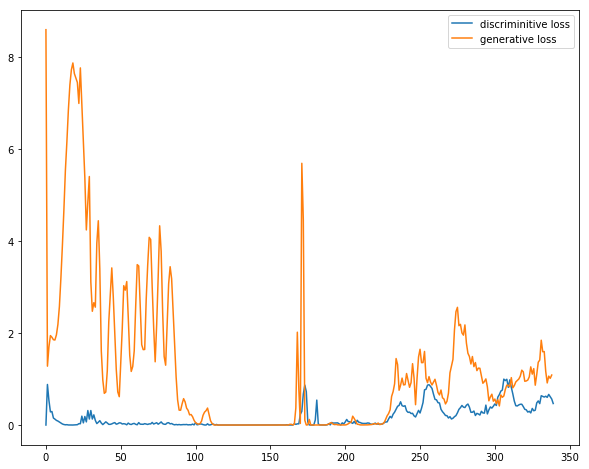

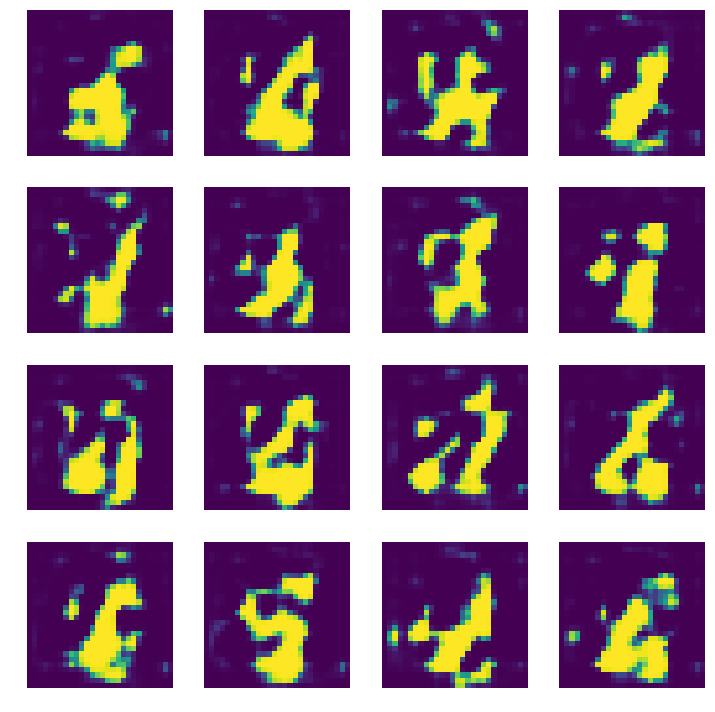


100%|████████████████████████████████████████████████████████████| 250/250 [50:56<00:00, 12.23s/it]


In [17]:
train_for_n(nb_epoch=250, plt_frq=25,BATCH_SIZE=128)

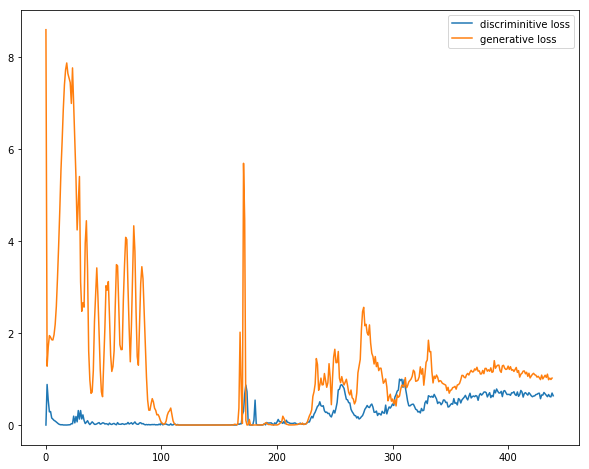

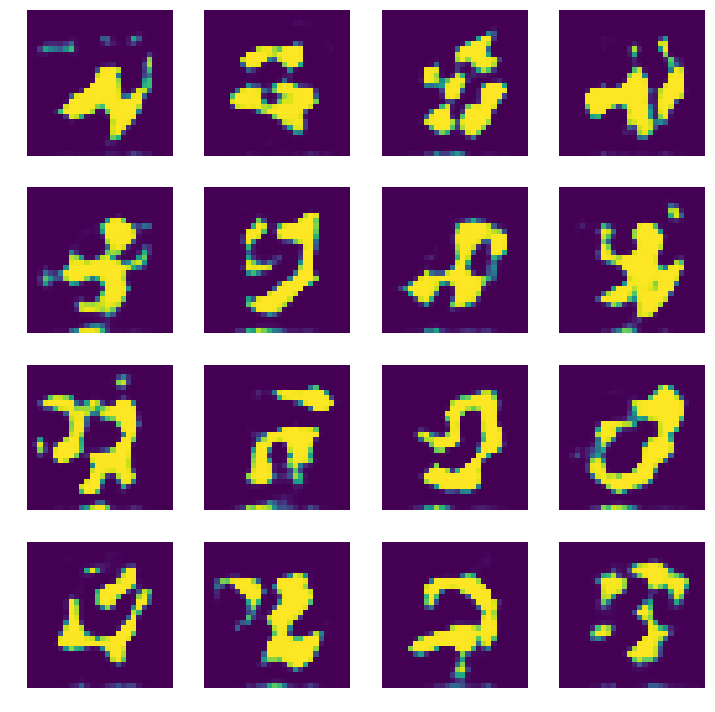


100%|████████████████████████████████████████████████████████████| 100/100 [19:44<00:00, 11.85s/it]


In [18]:
# 调整学习率、优化器参数值
K.set_value(opt.lr, 1e-4)
K.set_value(dopt.lr, 1e-5)
train_for_n(nb_epoch=100, plt_frq=10,BATCH_SIZE=128)

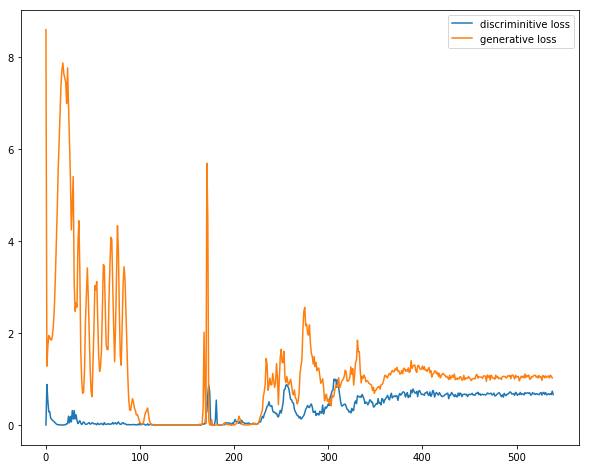

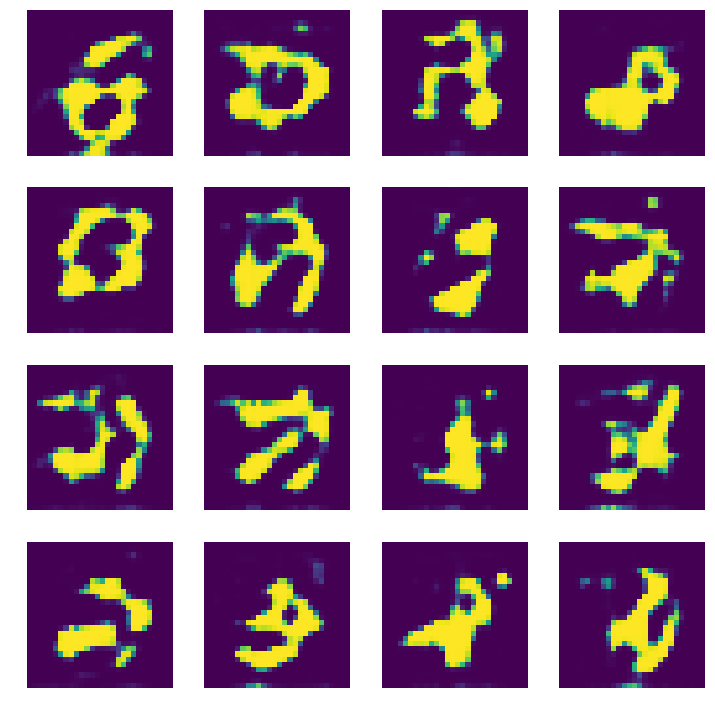


100%|████████████████████████████████████████████████████████████| 100/100 [39:20<00:00, 23.61s/it]


In [19]:
K.set_value(opt.lr, 1e-5)
K.set_value(dopt.lr, 1e-6)
train_for_n(nb_epoch=100, plt_frq=10,BATCH_SIZE=256)

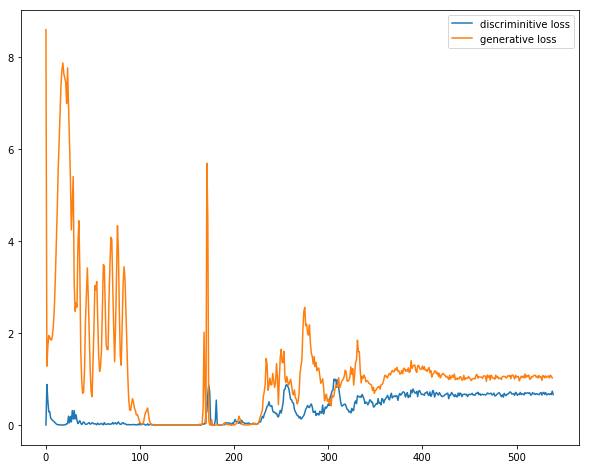

In [20]:
plot_loss(losses)

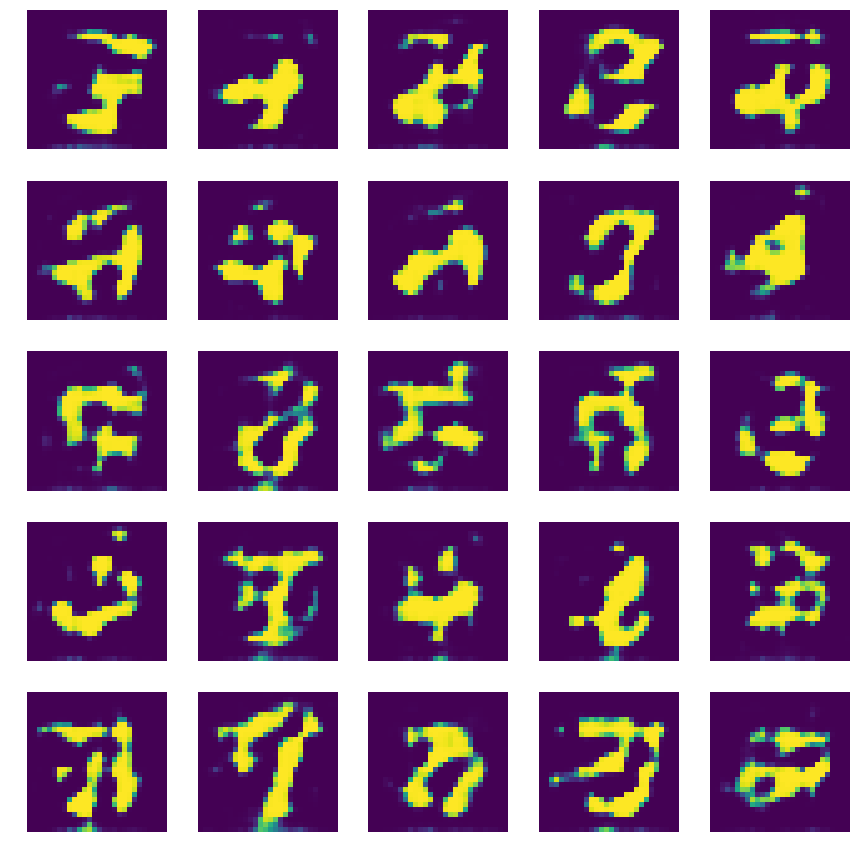

In [21]:
plot_gen(25,(5,5),(12,12))

In [22]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



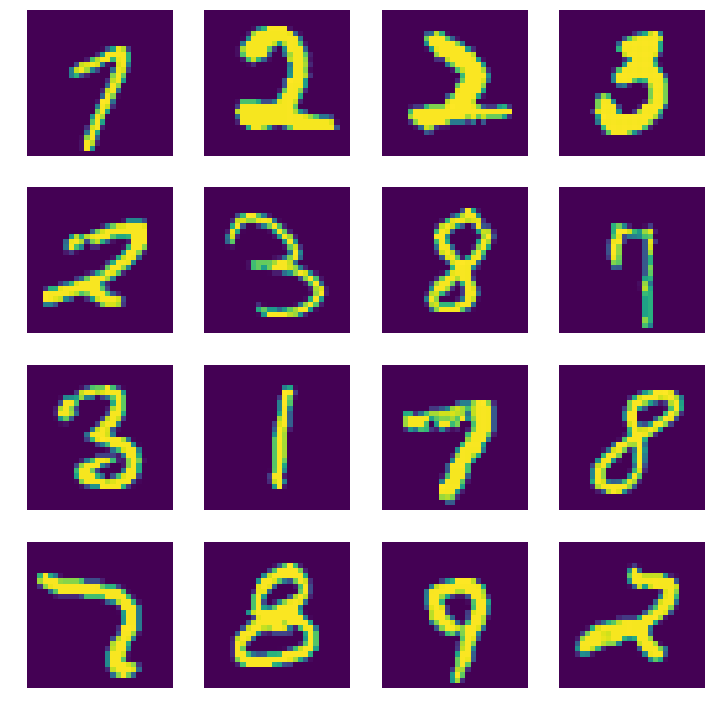

D:\anaconda\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [23]:
plot_real()